In [1]:
import torch
import torch.nn.functional as F

from thanh_transformers.x_transformers import TransformerWrapper, Decoder
from thanh_transformers.autoregressive_wrapper import top_k, top_p, entmax, ENTMAX_ALPHA
from thanh.models.vision_transformer_hybrid import HybridEmbed
from thanh.models.resnetv2 import ResNetV2
from thanh.models.layers import StdConv2dSame
from transformers import PreTrainedTokenizerFast
from utils import parse_args, pad, post_process, token2str
from test_transform import test_transform

In [206]:
def minmax_size(image, max_dimensions=None, min_dimensions=None):
    if max_dimensions is not None:
        ratios = [a/b for a, b in zip(image.size, max_dimensions)]
        if any([r > 1 for r in ratios]):
            size = np.array(image.size)//max(ratios)
            image = image.resize(size.astype(int), Image.BILINEAR)
    if min_dimensions is not None:
        if any([s < min_dimensions[i] for i, s in enumerate(image.size)]):
            padded_im = Image.new('L', min_dimensions, 255)
            padded_im.paste(image, image.getbbox())
            image = padded_im
    return image

In [207]:
from LatexModel import get_model
# from thanh_transformers.x_transformers import TransformerWrapper, Decoder
# from thanh.models.vision_transformer_hybrid import HybridEmbed
# from thanh.models.resnetv2 import ResNetV2
# from thanh.models.layers import StdConv2dSame

# from CustomVisionTransformer import CustomVisionTransformer
# from CustomARWrapper import CustomARWrapper
# from LatexModel import Model


In [226]:
from munch import Munch
import os
import yaml

arguments = None
if arguments is None:
    arguments = Munch({'config': 'settings/config.yaml', 'checkpoint': 'checkpoints/weights.pth', 'no_cuda': True, 'no_resize': False})
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
with open(arguments.config, 'r') as f:
    params = yaml.load(f, Loader=yaml.FullLoader)
args = parse_args(Munch(params))
args.update(**vars(arguments))
args.wandb = False
args.device = "cpu"
# args.device = 'cuda' if torch.cuda.is_available() and not args.no_cuda else 'cpu'

In [227]:
latexModel = get_model(args=args)

latexModel.load_state_dict(torch.load(args.checkpoint, map_location=args.device))
image_resizer = None

In [228]:
tokenizer = PreTrainedTokenizerFast(tokenizer_file=args.tokenizer)

In [229]:
encoder_model, decoder_model = latexModel.encoder, latexModel.decoder

(64, 160, 3)


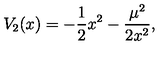

In [230]:
from PIL import Image
import numpy as np
image_equation = Image.open("./sample/10024a5ccf.png")
print(np.shape(image_equation))
image_equation

In [231]:
np_image = minmax_size(pad(image_equation), args.max_dimensions, args.min_dimensions)
np_image = np.array(pad(np_image).convert('RGB'))
t = test_transform(image=np_image)['image'][:1].unsqueeze(0)
tensor_image = t.to(args.device)
print(np.shape(tensor_image))

with torch.no_grad():
    latexModel.eval()
    device = args.device
    encoded = encoder_model(tensor_image)
    start_tokens = torch.LongTensor([args.bos_token])[:, None].to(device)
    encodeWeight = encoded.detach()
    dec = decoder_model.generate(start_tokens, args.max_seq_len,
                           eos_token=args.eos_token, context=encodeWeight, temperature=args.get('temperature', .25))
    tokenString = token2str(dec, tokenizer)[0]
    pred = post_process(tokenString)

pred

torch.Size([1, 1, 64, 160])


'V_{2}(x)=-{\\frac{1}{2}}x^{2}-{\\frac{\\mu^{2}}{2x^{2}}},'

In [ ]:
transWrapper = decoder_model.net
out = start_tokens
x = out[:, -args.max_seq_len:]
torch.onnx.export(transWrapper,               # model being run
                  x,                          # model input (or a tuple for multiple inputs)context=encoder(im)
                  "latex_encode.onnx",        # where to save the model (can be a file or file-like object)
                  export_params=True,         # store the trained parameter weights inside the model file
                  opset_version=11,           # the ONNX version to export the model to
                  do_constant_folding=True,   # whether to execute constant folding for optimization
                  input_names = ['input'],    # the model's input names
                  output_names = ['output'],  # the model's output names
                  dynamic_axes={'input' : {0 : 'batch_size'},    # variable length axes
                                'output' : {0 : 'batch_size'}})

In [ ]:
encodeWeight = encoded.detach()
# im = torch.empty(args.batchsize, args.channels, args.max_height, args.min_height, device=args.device).float()
seq = torch.randint(0, args.num_tokens, (args.batchsize, args.max_seq_len), device=args.device).long()
decoder_model(seq, context=encodeWeight).sum().backward()

In [ ]:
# device = start_tokens.device
# was_training = decoder_model.training
# num_dims = len(start_tokens.shape)

# if num_dims == 1:
#     start_tokens = start_tokens[None, :]

# b, t = start_tokens.shape

# decoder_model.eval()
# out = start_tokens
# # mask = kwargs.pop('mask', None)
# # if mask is None:
# #     mask = torch.full_like(
# #         out, True, dtype=torch.bool, device=out.device)

# for _ in range(seq_len):
#     x = out[:, -self.max_seq_len:]
#     mask = mask[:, -self.max_seq_len:]
#     # print('arw:',out.shape)
#     logits = self.net(x, mask=mask, **kwargs)[:, -1, :]

#     if filter_logits_fn in {top_k, top_p}:
#         filtered_logits = filter_logits_fn(logits, thres=filter_thres)
#         probs = F.softmax(filtered_logits / temperature, dim=-1)

#     sample = torch.multinomial(probs, 1)

#     out = torch.cat((out, sample), dim=-1)
#     mask = F.pad(mask, (0, 1), value=True)

#     if eos_token is not None and (torch.cumsum(out == eos_token, 1)[:, -1] >= 1).all():
#         break

# out = out[:, t:]

# if num_dims == 1:
#     out = out.squeeze(0)

# decoder_model.net.train(was_training)

In [232]:

# ///////////////////////////
start_tokens = torch.LongTensor([args.bos_token])[:, None].to(device)
seq_len = args.max_seq_len
eos_token=args.eos_token
temperature=1.
filter_logits_fn=top_k
filter_thres=0.9
# ///////////////////////////
device = start_tokens.device
was_training = decoder_model.net.training
num_dims = len(start_tokens.shape)

if num_dims == 1:
    start_tokens = start_tokens[None, :]

b, t = start_tokens.shape

decoder_model.net.eval()
out = start_tokens
mask = args.pop('mask', None)
if mask is None:
    mask = torch.full_like(out, True, dtype=torch.bool, device=out.device)

for _ in range(seq_len):
    x = out[:, -args.max_seq_len:]
    mask = mask[:, -args.max_seq_len:]

    logits = decoder_model.net(x, mask=mask, **args)[:, -1, :]

    if filter_logits_fn in {top_k, top_p}:
        filtered_logits = filter_logits_fn(logits, thres = filter_thres)
        probs = F.softmax(filtered_logits / temperature, dim=-1)

    elif filter_logits_fn is entmax:
        probs = entmax(logits / temperature, alpha = ENTMAX_ALPHA, dim=-1)

    sample = torch.multinomial(probs, 1)

    out = torch.cat((out, sample), dim=-1)
    mask = F.pad(mask, (0, 1), value=True)

    if eos_token is not None and (sample == eos_token).all():
        break

out = out[:, t:]

if num_dims == 1:
    out = out.squeeze(0)

decoder_model.net.train(was_training)

TypeError: forward() got an unexpected keyword argument 'epoch'

In [14]:
# # make_dot(latexModel(im.to(device)), params=dict(latexModel.named_parameters()))
# from CustomVisionTransformer import CustomVisionTransformer
# backbone = ResNetV2(
#     layers=args.backbone_layers, num_classes=0, global_pool='', in_chans=args.channels,
#     preact=False, stem_type='same', conv_layer=StdConv2dSame)
# min_patch_size = 2**(len(args.backbone_layers)+1)

# def embed_layer(**x):
#     ps = x.pop('patch_size', min_patch_size)
#     assert ps % min_patch_size == 0 and ps >= min_patch_size, 'patch_size needs to be multiple of %i with current backbone configuration' % min_patch_size
#     return HybridEmbed(**x, patch_size=ps//min_patch_size, backbone=backbone)

# encoder = CustomVisionTransformer(img_size=(args.max_height, args.max_width),
#                                     patch_size=args.patch_size,
#                                     in_chans=args.channels,
#                                     num_classes=0,
#                                     embed_dim=args.dim,
#                                     depth=args.encoder_depth,
#                                     num_heads=args.heads,
#                                     embed_layer=embed_layer
#                                     ).to(args.device)

In [15]:
# dot = make_dot(encoder(im.to(device)), params=dict(encoder.named_parameters()))

# dot.format = 'svg'
# dot.render()

In [16]:
# torch.onnx.export(encoder,               # model being run
#                   im.to(device),                         # model input (or a tuple for multiple inputs)
#                   "latex_encode.onnx",   # where to save the model (can be a file or file-like object)
#                   export_params=True,        # store the trained parameter weights inside the model file
#                   opset_version=11,          # the ONNX version to export the model to
#                   do_constant_folding=True,  # whether to execute constant folding for optimization
#                   input_names = ['input'],   # the model's input names
#                   output_names = ['output'], # the model's output names
#                   dynamic_axes={'input' : {0 : 'batch_size'},    # variable length axes
#                                 'output' : {0 : 'batch_size'}})

In [17]:
# torch.onnx.export(encoder,               # model being run
#                   im.to(device),                         # model input (or a tuple for multiple inputs)
#                   "latex_encode.onnx",   # where to save the model (can be a file or file-like object)
#                   export_params=True,        # store the trained parameter weights inside the model file
#                   opset_version=11,          # the ONNX version to export the model to
#                   do_constant_folding=True,  # whether to execute constant folding for optimization
#                   input_names = ['input'],   # the model's input names
#                   output_names = ['output'], # the model's output names
#                   dynamic_axes={'input' : {0 : 'batch_size'},    # variable length axes
#                                 'output' : {0 : 'batch_size'}})

In [19]:
# im = torch.empty(args.batchsize, args.channels, args.max_height, args.min_height, device=args.device).float()
# seq = torch.randint(0, args.num_tokens, (args.batchsize, args.max_seq_len), device=args.device).long()
# decoder(seq, context=encoder(im))

In [20]:
# torch.onnx.export(decoder,               # model being run
#                   seq,                         # model input (or a tuple for multiple inputs)context=encoder(im)
#                   "latex_encode.onnx",   # where to save the model (can be a file or file-like object)
#                   export_params=True,        # store the trained parameter weights inside the model file
#                   opset_version=11,          # the ONNX version to export the model to
#                   do_constant_folding=True,  # whether to execute constant folding for optimization
#                   input_names = ['input'],   # the model's input names
#                   output_names = ['output'], # the model's output names
#                   dynamic_axes={'input' : {0 : 'batch_size'},    # variable length axes
#                                 'output' : {0 : 'batch_size'}})

In [24]:
# from torch.utils.tensorboard import SummaryWriter

# writer = SummaryWriter()

# writer.add_graph(encoder,im.to(device))

In [25]:
# backbone = ResNetV2(
#     layers=args.backbone_layers, num_classes=0, global_pool='', in_chans=args.channels,
#     preact=False, stem_type='same', conv_layer=StdConv2dSame)

# from zetane import TorchViz

In [26]:
# from zetane import TorchViz

# viz = TorchViz()
# viz.create_torch_model(encoder, im.to(device))
# viz.model_inference(im.to(device))

In [196]:
start_tokens = torch.LongTensor([args.bos_token])[:, None].to(device)
seq_len = 256
eos_token = args.eos_token
temperature = .2
filter_logits_fn = top_k
filter_thres = 0.9
context = encodeWeight

In [235]:
# # out = start_tokens
# # mask = args.pop('mask', None)
# # if mask is None:
# #     mask = torch.full_like(out, True, dtype=torch.bool, device=out.device)

# # x = out[:, -args.max_seq_len:]
# # mask = mask[:, -args.max_seq_len:]
# encodeWeight = encoded.detach()
# # decoder_model.net(x, mask=mask, context=encodeWeight)

# decoder_model(start_tokens,
#               seq_len=args.max_seq_len,
#               eos_token=args.eos_token,
#               temperature=.2,
#               context=encodeWeight)
# tokenString = token2str(dec, tokenizer)[0]
# pred = post_process(tokenString)
# pred

decoder_model(start_tokens,
              seq_len=args.max_seq_len,
              eos_token=args.eos_token,
              temperature=.2,
              context=encodeWeight)
tokenString = token2str(dec, tokenizer)[0]
pred = post_process(tokenString)
pred

'V_{2}(x)=-{\\frac{1}{2}}x^{2}-{\\frac{\\mu^{2}}{2x^{2}}},'

In [216]:
max_seq_len = args.max_seq_len
traced_cell = torch.jit.trace(decoder_model, (start_tokens, context))

TypeError: only integer tensors of a single element can be converted to an index

torch.Size([1, 41, 256])

In [187]:
torch.onnx.export(decoder,               # model being run
                  # model input (or a tuple for multiple inputs)context=encoder(im)
                  (start_tokens, max_seq_len, eos_token, temperature, context),
                  # where to save the model (can be a file or file-like object)
                  "latex_decode.onnx",
                  export_params=True,        # store the trained parameter weights inside the model file
                  opset_version=11,          # the ONNX version to export the model to
                  do_constant_folding=True,  # whether to execute constant folding for optimization
                  input_names=['input'],   # the model's input names
                  output_names=['output'],  # the model's output names
                  dynamic_axes={'input': {0: 'batch_size'},    # variable length axes
                                'output': {0: 'batch_size'}})


AssertionError: context must be passed in if cross_attend is set to True

In [159]:
class MyCell(torch.nn.Module):
    def __init__(self):
        super(MyCell, self).__init__()
        self.linear = torch.nn.Linear(4, 4)

    def forward(self, x, context):
        new_h = torch.tanh(self.linear(x) + h)
        return new_h, new_h

my_cell = MyCell()
x = torch.rand(3, 4)
context= torch.rand(3, 4)
traced_cell = torch.jit.trace(my_cell, (x, context))
print(traced_cell)
traced_cell(x, context)

MyCell(
  original_name=MyCell
  (linear): Linear(original_name=Linear)
)


(tensor([[0.6667, 0.9323, 0.3032, 0.6710],
         [0.5033, 0.8415, 0.3883, 0.9128],
         [0.5966, 0.7419, 0.4599, 0.8341]], grad_fn=<TanhBackward0>),
 tensor([[0.6667, 0.9323, 0.3032, 0.6710],
         [0.5033, 0.8415, 0.3883, 0.9128],
         [0.5966, 0.7419, 0.4599, 0.8341]], grad_fn=<TanhBackward0>))

In [170]:
traced_cell = torch.jit.trace(encoder_model, im.to(device))
print(traced_cell)

tensor([[[-0.0364, -0.0342, -0.0122,  ..., -0.0185, -0.0135,  0.0023],
         [ 0.1347,  0.0388,  0.2878,  ..., -0.0078, -0.0010,  0.0016],
         [-0.2407,  0.0618,  0.1151,  ..., -0.1899, -0.0018,  0.0011],
         ...,
         [ 0.0145,  0.0773, -0.1272,  ..., -0.1472,  0.0039,  0.0012],
         [ 0.2215,  0.1679, -0.2498,  ..., -0.0849,  0.0022,  0.0022],
         [ 0.2342,  0.1548, -0.2931,  ...,  0.0595,  0.0006,  0.0014]]],
       grad_fn=<NativeLayerNormBackward0>)

In [192]:
traced_cell = torch.jit.trace(decoder_model,
                              (start_tokens, seq_len, eos_token, temperature, filter_logits_fn, filter_thres, context))

RuntimeError: Tracer cannot infer type of (tensor([[1]]), 512, 2, 0.2, <function top_k at 0x7f967ad11a70>, 0.9, tensor([[[-0.0364, -0.0342, -0.0122,  ..., -0.0185, -0.0135,  0.0023],
         [ 0.1347,  0.0388,  0.2878,  ..., -0.0078, -0.0010,  0.0016],
         [-0.2407,  0.0618,  0.1151,  ..., -0.1899, -0.0018,  0.0011],
         ...,
         [ 0.0145,  0.0773, -0.1272,  ..., -0.1472,  0.0039,  0.0012],
         [ 0.2215,  0.1679, -0.2498,  ..., -0.0849,  0.0022,  0.0022],
         [ 0.2342,  0.1548, -0.2931,  ...,  0.0595,  0.0006,  0.0014]]]))
:Only tensors and (possibly nested) tuples of tensors, lists, or dictsare supported as inputs or outputs of traced functions, but instead got value of type function.